## Computational Challenge 5

Group \#4

Students: Danial Asgari, Michael Batista, Youssaf Menacer, and Alan Akil

Course: Math 6397 - Stochastic Processes in Biology

Professors: Dr. Josić & Dr. Stewart

$\textbf{Challenge:}$


In this challenge two groups will report on the deterministic version of models of these circuits, while the other two will report on the stochastic versions. The last part of each question asks that you compare the results of the simulations. Therefore groups 1 and 2, and groups 3 and 4 will need to work together on each project.

A feed-forward loop (FFL) is a 3-gene genetic circuit in which two “input” transcription factors (TFs), $X$ and $Y$, regulate a third “target” $Z$, with TF $X$ also regulating TF $Y$. Depending on the pattern of activation and repression among the three genes, an FFL can speed or slow the response time of $Z$ to a stimulus in the form of $X$ switching ON or OFF. Here we will explore the behavor of the so-called “incoherent” FFL.
We will assume that X is either OFF or ON such that the concentration of the product of gene $X$ is $X_∗$ where $X_∗ =1$ when the geneis ON and $X∗ =0$when the gene is OFF. We will look at two specific cases of an incoherent FFL.



Work with Group 3 to understand the behavior of the different circuits in response to changes in the input X.

(a) Construct a Petri Net describing a stochastic version of the two FFLs. Assuming the ODEs describe concentrations, suggest reasonable values for reaction rates that will produce at most a few hundred molecules in the products of all three genes, while retaining the regulatory relationships of the deterministic system.

(b) Implement a stochastic simulation corresponding to the two FFLs above using the Gillespie Algorithm.

(c) Estimate the ON-to-OFF and OFF-to-ON response times with strong $Y−Z$ regulation for the two FFL cases.

(d) Assuming $X$ is ON, plot the stationary distribution for the expression of $Z$ with strong $Y-Z$ regulation for the two FFL cases.

## Petri Net of the system
![title](./Petri-comp-5.png)


In [1]:
# Import packages needed.
import numpy as np
import random
from scipy.special import gamma, factorial
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import tqdm
from numba import jit
from numba import njit, prange
import time
from scipy.integrate import solve_ivp

## Define the function for simulating Case 1 and 2

In [2]:
# @jit
def sim_case1(x,By,beta_y,alpha_y,Bz,beta_z,alpha_z,k_xy,k_xz,k_yz,T,time_on_init,time_on_end):
    # x=[Y,Z] is the molecule count of each species.
    t_x=[0] # reaction time of fully-observed trajectory
    i=0
    # Reaction matrix.
    v=np.array([[1,0],[-1,0],[0,1],[0,-1]])
    while t_x[i]<T:
        if time_on_init<t_x[i]<time_on_end:
            X=1
        else:
            X=0
        # Propensity functions
        a = np.array([By+beta_y * (((X/k_xy)**h)/(1+((X/k_xy)**h))), alpha_y * x[i,0],
                     Bz+beta_z * (((X/k_xz)**h)/(1+((X/k_xz)**h)))*(1/(1+((x[i,0]/k_yz)**h)))
                      ,alpha_z * x[i,1]])
        sum_a=np.sum(a)
        cumsum_a=np.cumsum(a,axis=0)
        # Draw 2 random numbers from U(0,1)
        epsilon=np.random.uniform(0,1,2)
        # Find the reaction that will take place next.
        j=np.min(np.where(epsilon[0]*sum_a<cumsum_a))
        # Compute the time until reaction j happens.
        tau=(np.log(1/epsilon[1]))/sum_a
        # Update molecule counts due to reaction j happening.
        x=np.append(x,[x[i,:]+v[j,:]],axis=0)
        # Update time of simulation.
        t_x=np.append(t_x,[t_x[i]+tau])
        i+=1
    return x,t_x

# @jit
def sim_case2(x,By,beta_y,alpha_y,Bz,beta_z,alpha_z,k_xy,k_xz,k_yz,T,time_on_init,time_on_end):
    # x=[Y,Z] is the molecule count of each species.
    t_x=[0] # reaction time of fully-observed trajectory
    i=0
    # Reaction matrix.
    v=np.array([[1,0],[-1,0],[0,1],[0,-1]])
    while t_x[i]<T:
        if time_on_init<t_x[i]<time_on_end:
            X=1
        else:
            X=0
        # Propensity functions
        a = np.array([By+beta_y * (1/(1+((X/k_xy)**h))), alpha_y * x[i,0],
                     Bz+beta_z * (1/(1+((X/k_xz)**h)))*(1/(1+((x[i,0]/k_yz)**h)))
                      ,alpha_z * x[i,1]])
        sum_a=np.sum(a)
        cumsum_a=np.cumsum(a,axis=0)
        # Draw 2 random numbers from U(0,1)
        epsilon=np.random.uniform(0,1,2)
        # Find the reaction that will take place next.
        j=np.min(np.where(epsilon[0]*sum_a<cumsum_a))
        # Compute the time until reaction j happens.
        tau=(np.log(1/epsilon[1]))/sum_a
        # Update molecule counts due to reaction j happening.
        x=np.append(x,[x[i,:]+v[j,:]],axis=0)
        # Update time of simulation.
        t_x=np.append(t_x,[t_x[i]+tau])
        i+=1
    return x,t_x

## Sample simulation of case 1

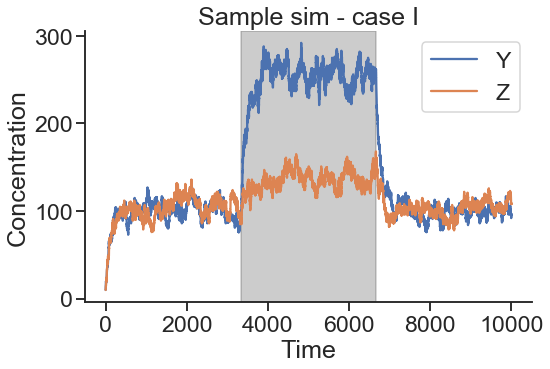

Shaded area indicates that X was ON.


In [6]:
# Case 1 - sample simulation
By = 1; beta_y = 3; alpha_y = 0.01;
Bz = 1; beta_z = 3; alpha_z = 0.01;
k_xy = 1; k_xz = 1; k_yz = 0.01 *10**0;
h = 0.1
y_0 = 10
z_0 = 10
x = np.array([y_0,z_0]).reshape(1,2)
T = 10000
time_on_init = T//3
time_on_end = 2*T//3

np.random.seed(2)

x,t_x = sim_case1(x,By,beta_y,alpha_y,Bz,beta_z,alpha_z,k_xy,k_xz,k_yz,T,time_on_init,time_on_end)


# Create figure and plot 
## Plot results
fig=plt.figure(figsize=(8,5))
ax = plt.subplot(111)

sns.set()
sns.set_style('whitegrid')
sns.set_style('white')
sns.set_style("ticks")
sns.set_context("talk", font_scale=1.4, rc={"lines.linewidth":2.3})

# Shade area where laser is ON.
ax.axvspan(time_on_init, time_on_end, alpha=0.2, color='black')

plt.plot(t_x,x[:,0],label='Y')
plt.plot(t_x,x[:,1],label='Z')

plt.xlabel('Time')
plt.ylabel('Concentration')

plt.legend()
sns.despine()

plt.title(r'Sample sim - case I')

plt.show()

print('Shaded area indicates that X was ON.')

## Sample simulation of case 2

/opt/anaconda3/envs/bmnn/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


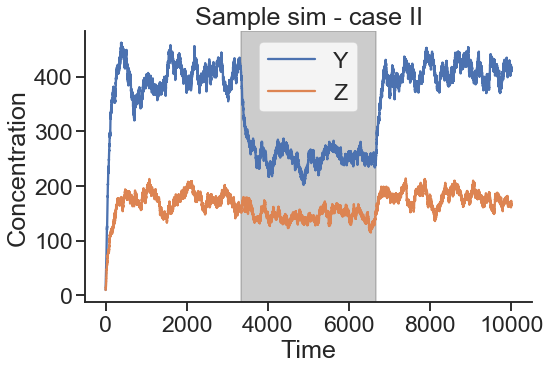

Shaded area indicates that X was ON.


In [65]:
# Case 2 - sample simulation
By = 1; beta_y = 3; alpha_y = 0.01;
Bz = 1; beta_z = 3; alpha_z = 0.01;
k_xy = 1; k_xz = 1; k_yz = 0.01 *10**0;
h = 0.1
y_0 = 10
z_0 = 10
x = np.array([y_0,z_0]).reshape(1,2)
T = 10000
time_on_init = T//3
time_on_end = 2*T//3

np.random.seed(2)

x,t_x = sim_case2(x,By,beta_y,alpha_y,Bz,beta_z,alpha_z,k_xy,k_xz,k_yz,T,time_on_init,time_on_end)


# Create figure and plot 
## Plot results
fig=plt.figure(figsize=(8,5))
ax = plt.subplot(111)

sns.set()
sns.set_style('whitegrid')
sns.set_style('white')
sns.set_style("ticks")
sns.set_context("talk", font_scale=1.4, rc={"lines.linewidth":2.3})

# Shade area where laser is ON.
ax.axvspan(time_on_init, time_on_end, alpha=0.2, color='black')

plt.plot(t_x,x[:,0],label='Y')
plt.plot(t_x,x[:,1],label='Z')

plt.xlabel('Time')
plt.ylabel('Concentration')

plt.legend()
sns.despine()

plt.title(r'Sample sim - case II')

plt.show()

print('Shaded area indicates that X was ON.')

## How does varying $Y-Z$ regulation affect Y and Z?

Case 1


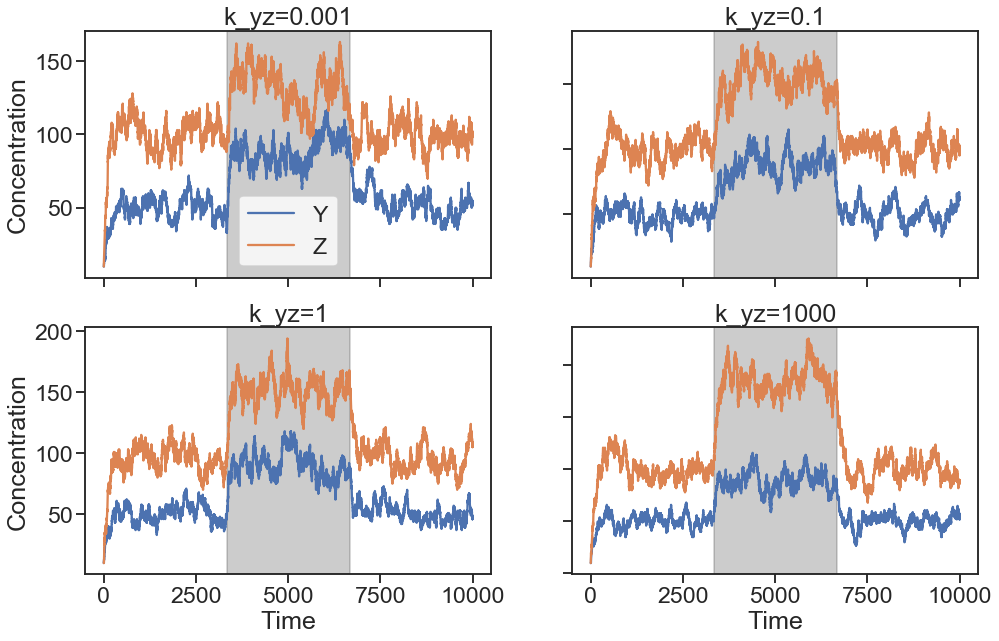

In [11]:
# Case 1 - varying Y - Z regulation
By = .5; beta_y = 0.8; alpha_y = 0.01;
Bz = 1; beta_z = 3; alpha_z = 0.01;
k_xy = 1; k_xz = 1; k_yz = 0.001 *10**0;
h = 0.1
y_0 = 10
z_0 = 10
x = np.array([y_0,z_0]).reshape(1,2)
T = 10000
time_on_init = T//3
time_on_end = 2*T//3

np.random.seed(2)

print('Case 1')

x,t_x = sim_case1(x,By,beta_y,alpha_y,Bz,beta_z,alpha_z,k_xy,k_xz,k_yz,T,time_on_init,time_on_end)

fig, axs = plt.subplots(2, 2, figsize=(16,10))
axs[0, 0].plot(t_x, x[:,0],label='Y')
axs[0, 0].plot(t_x, x[:,1],label='Z')
axs[0, 0].set_title('k_yz=0.001')
axs[0, 0].legend()
axs[0, 0].axvspan(time_on_init, time_on_end, alpha=0.2, color='black')

x = np.array([y_0,z_0]).reshape(1,2)
k_yz = 0.1
x,t_x = sim_case1(x,By,beta_y,alpha_y,Bz,beta_z,alpha_z,k_xy,k_xz,k_yz,T,time_on_init,time_on_end)
axs[0, 1].plot(t_x, x[:,0])
axs[0, 1].plot(t_x, x[:,1])
axs[0, 1].set_title('k_yz=0.1')
axs[0, 1].axvspan(time_on_init, time_on_end, alpha=0.2, color='black')

x = np.array([y_0,z_0]).reshape(1,2)
k_yz = 1
x,t_x = sim_case1(x,By,beta_y,alpha_y,Bz,beta_z,alpha_z,k_xy,k_xz,k_yz,T,time_on_init,time_on_end)
axs[1, 0].plot(t_x, x[:,0])
axs[1, 0].plot(t_x, x[:,1])
axs[1, 0].set_title('k_yz=1')
axs[1, 0].axvspan(time_on_init, time_on_end, alpha=0.2, color='black')

x = np.array([y_0,z_0]).reshape(1,2)
k_yz = 10**3
x,t_x = sim_case1(x,By,beta_y,alpha_y,Bz,beta_z,alpha_z,k_xy,k_xz,k_yz,T,time_on_init,time_on_end)
axs[1, 1].plot(t_x, x[:,0])
axs[1, 1].plot(t_x, x[:,1])
axs[1, 1].set_title('k_yz=1000')
axs[1, 1].axvspan(time_on_init, time_on_end, alpha=0.2, color='black')


for ax in axs.flat:
    ax.set(xlabel='Time', ylabel='Concentration')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

Case 2


/opt/anaconda3/envs/bmnn/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


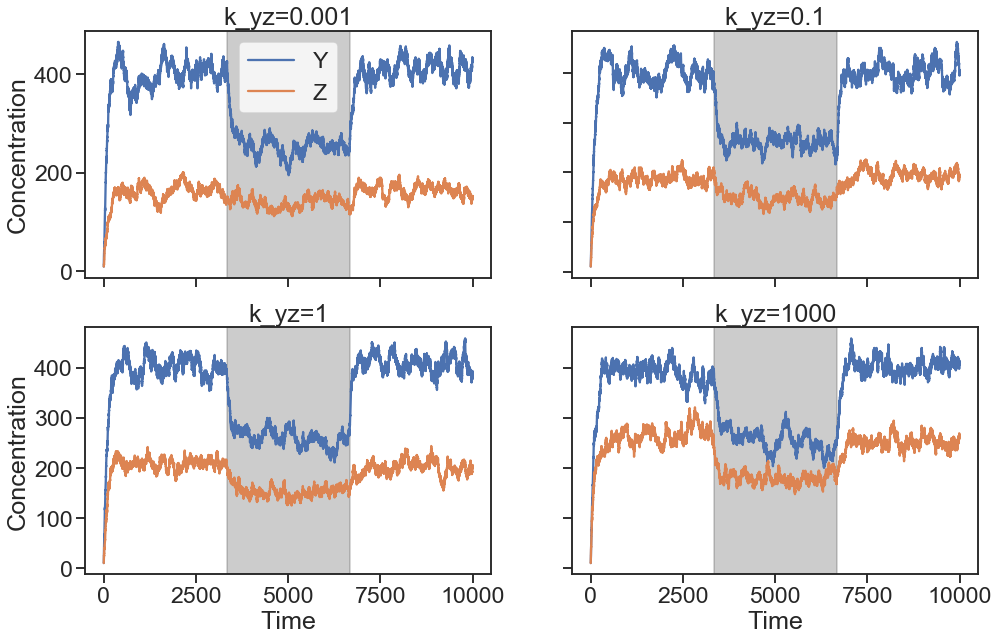

In [132]:
# Case 2 - varying Y - Z regulation
By = 1; beta_y = 3; alpha_y = 0.01;
Bz = 1; beta_z = 3; alpha_z = 0.01;
k_xy = 1; k_xz = 1; k_yz = 0.001 *10**0;
h = 0.1
y_0 = 10
z_0 = 10
x = np.array([y_0,z_0]).reshape(1,2)
T = 10000
time_on_init = T//3
time_on_end = 2*T//3

np.random.seed(2)

print('Case 2')

x,t_x = sim_case2(x,By,beta_y,alpha_y,Bz,beta_z,alpha_z,k_xy,k_xz,k_yz,T,time_on_init,time_on_end)

fig, axs = plt.subplots(2, 2, figsize=(16,10))
axs[0, 0].plot(t_x, x[:,0],label='Y')
axs[0, 0].plot(t_x, x[:,1],label='Z')
axs[0, 0].set_title('k_yz=0.001')
axs[0, 0].legend()
axs[0, 0].axvspan(time_on_init, time_on_end, alpha=0.2, color='black')

x = np.array([y_0,z_0]).reshape(1,2)
k_yz = 0.1
x,t_x = sim_case2(x,By,beta_y,alpha_y,Bz,beta_z,alpha_z,k_xy,k_xz,k_yz,T,time_on_init,time_on_end)
axs[0, 1].plot(t_x, x[:,0])
axs[0, 1].plot(t_x, x[:,1])
axs[0, 1].set_title('k_yz=0.1')
axs[0, 1].axvspan(time_on_init, time_on_end, alpha=0.2, color='black')

x = np.array([y_0,z_0]).reshape(1,2)
k_yz = 1
x,t_x = sim_case2(x,By,beta_y,alpha_y,Bz,beta_z,alpha_z,k_xy,k_xz,k_yz,T,time_on_init,time_on_end)
axs[1, 0].plot(t_x, x[:,0])
axs[1, 0].plot(t_x, x[:,1])
axs[1, 0].set_title('k_yz=1')
axs[1, 0].axvspan(time_on_init, time_on_end, alpha=0.2, color='black')

x = np.array([y_0,z_0]).reshape(1,2)
k_yz = 10**3
x,t_x = sim_case2(x,By,beta_y,alpha_y,Bz,beta_z,alpha_z,k_xy,k_xz,k_yz,T,time_on_init,time_on_end)
axs[1, 1].plot(t_x, x[:,0])
axs[1, 1].plot(t_x, x[:,1])
axs[1, 1].set_title('k_yz=1000')
axs[1, 1].axvspan(time_on_init, time_on_end, alpha=0.2, color='black')


for ax in axs.flat:
    ax.set(xlabel='Time', ylabel='Concentration')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    

## Estimate the ON-to-OFF and OFF-to-ON response times with strong $Y-Z$ regulation

In [243]:
# Case 1 - Response time calculation - high k_yz
By = 1; beta_y = 3; alpha_y = 0.01;
Bz = 1; beta_z = 3; alpha_z = 0.01;
k_xy = 1; k_xz = 1; k_yz = 0.01 *10**5;
h = 0.1
y_0 = 10
z_0 = 10
x = np.array([y_0,z_0]).reshape(1,2)
T = 10000
time_on_init = T//3
time_on_end = 2*T//3

Num_realizations = 200
response_time_off_to_on = np.zeros(Num_realizations)
response_time_on_to_off = np.zeros(Num_realizations)
threshold = 5

for i in range(Num_realizations):
    start_time = time.time() # start timing
    np.random.seed(i)
    x = np.array([y_0,z_0]).reshape(1,2)
    x,t_x = sim_case1(x,By,beta_y,alpha_y,Bz,beta_z,alpha_z,
                      k_xy,k_xz,k_yz,T,time_on_init,time_on_end)
    # Compute OFF to ON response time
    indx_start_X_on = np.argmin(np.abs(t_x-T//3))
    indx_end_X_on = np.argmin(np.abs(t_x-2*T//3))
    x_mean_X_on = np.mean(x[indx_start_X_on:indx_end_X_on,1])
    response_time_off_to_on[i] = t_x[(np.abs(x[:,1]-x_mean_X_on)<threshold)][0]- time_on_init
    # Compute ON to OFF response time
    x_mean_X_off = np.mean(x[indx_end_X_on:-1,1])
    response_time_on_to_off[i] = t_x[(np.abs(x[:,1]-x_mean_X_off)<threshold) 
                                     & (t_x>2*T//3)][0] - time_on_end
    stop_time = time.time() # stop timing
    print('Simulation time:',stop_time-start_time,'sec')


Simulation time: 4.186168193817139 sec
Simulation time: 4.3191139698028564 sec
Simulation time: 4.7519307136535645 sec
Simulation time: 4.074310302734375 sec
Simulation time: 4.528484106063843 sec
Simulation time: 4.131413221359253 sec
Simulation time: 4.4819111824035645 sec
Simulation time: 4.396237134933472 sec
Simulation time: 4.273483991622925 sec
Simulation time: 4.153943777084351 sec
Simulation time: 4.1761085987091064 sec
Simulation time: 4.096384763717651 sec
Simulation time: 4.130431890487671 sec
Simulation time: 4.149372339248657 sec
Simulation time: 4.137410879135132 sec
Simulation time: 4.089859247207642 sec
Simulation time: 3.9595320224761963 sec
Simulation time: 3.9804399013519287 sec
Simulation time: 4.06545090675354 sec
Simulation time: 4.012998819351196 sec
Simulation time: 3.8917598724365234 sec
Simulation time: 4.12038516998291 sec
Simulation time: 4.1528449058532715 sec
Simulation time: 4.000303268432617 sec
Simulation time: 4.371323108673096 sec
Simulation time: 5.

Case 1, High k_yz


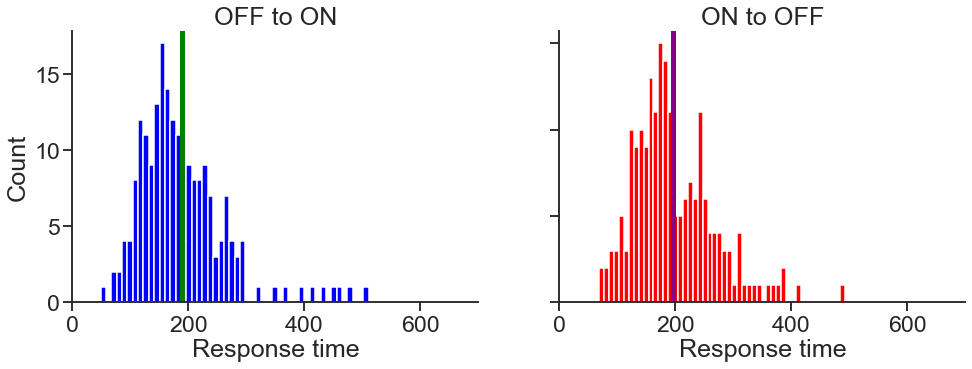

In [244]:
print('Case 1, High k_yz')
# Create figure and plot 
fig, axs = plt.subplots(1, 2, figsize=(16,5))
axs[0].hist(response_time_off_to_on,bins=50,color='blue')
axs[0].set_title('OFF to ON')
axs[0].axvline(x=np.mean(response_time_off_to_on),color='green',
              linewidth=5)

axs[1].hist(response_time_on_to_off,bins=50,color='red')
axs[1].set_title('ON to OFF')
axs[1].axvline(x=np.mean(response_time_on_to_off),color='darkmagenta',
              linewidth=5)

for ax in axs.flat:
    ax.set(xlabel='Response time', ylabel='Count',
          xlim=(0,700))
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

sns.despine()
    
plt.show()

In [17]:
# Case 1 - Response time calculation - low k_yz
By = .5; beta_y = .8; alpha_y = 0.01;
Bz = 1; beta_z = 3; alpha_z = 0.01;
k_xy = 1; k_xz = 1; k_yz = 0.01 *10**0;
h = 0.1
y_0 = 10
z_0 = 10
x = np.array([y_0,z_0]).reshape(1,2)
T = 10000
time_on_init = T//3
time_on_end = 2*T//3

Num_realizations = 200
response_time_off_to_on = np.zeros(Num_realizations)
response_time_on_to_off = np.zeros(Num_realizations)
threshold = 5

# @jit()
for i in range(Num_realizations):
    start_time = time.time() # start timing
    np.random.seed(i)
    x = np.array([y_0,z_0]).reshape(1,2)
    x,t_x = sim_case1(x,By,beta_y,alpha_y,Bz,beta_z,alpha_z,
                      k_xy,k_xz,k_yz,T,time_on_init,time_on_end)
    # Compute OFF to ON response time
    indx_start_X_on = np.argmin(np.abs(t_x-T//3))
    indx_end_X_on = np.argmin(np.abs(t_x-2*T//3))
    x_mean_X_on = np.mean(x[indx_start_X_on:indx_end_X_on,1])
    response_time_off_to_on[i] = t_x[(np.abs(x[:,1]-x_mean_X_on)<threshold) 
                                    & (t_x>time_on_init)][0]- time_on_init
    # Compute ON to OFF response time
    x_mean_X_off = np.mean(x[indx_end_X_on:-1,1])
    response_time_on_to_off[i] = t_x[(np.abs(x[:,1]-x_mean_X_off)<threshold) 
                                     & (t_x>time_on_end)][0] - time_on_end
    stop_time = time.time() # stop timing
    print('Simulation time:',stop_time-start_time,'sec')




Simulation time: 2.461336851119995 sec
Simulation time: 2.7363340854644775 sec
Simulation time: 2.5793049335479736 sec
Simulation time: 2.293205976486206 sec
Simulation time: 2.2570438385009766 sec
Simulation time: 2.2771949768066406 sec
Simulation time: 2.3096320629119873 sec
Simulation time: 2.3303370475769043 sec
Simulation time: 2.302406072616577 sec
Simulation time: 2.3107728958129883 sec
Simulation time: 2.2516229152679443 sec
Simulation time: 2.286158800125122 sec
Simulation time: 2.276945114135742 sec
Simulation time: 2.30452823638916 sec
Simulation time: 2.3032331466674805 sec
Simulation time: 2.291826009750366 sec
Simulation time: 2.2971227169036865 sec
Simulation time: 2.242284059524536 sec
Simulation time: 2.2635340690612793 sec
Simulation time: 2.3576560020446777 sec
Simulation time: 2.326051950454712 sec
Simulation time: 2.2624728679656982 sec
Simulation time: 2.3451359272003174 sec
Simulation time: 2.2753758430480957 sec
Simulation time: 2.2401788234710693 sec
Simulation

Case 1, Low k_yz


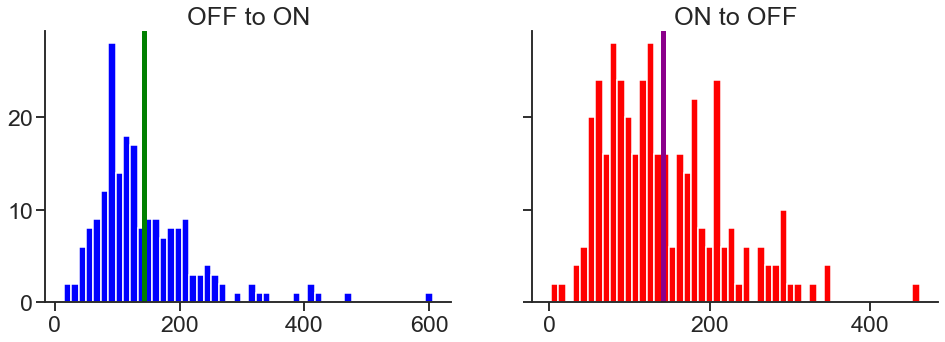

In [18]:
print('Case 1, Low k_yz')
# Create figure and plot 
fig, axs = plt.subplots(1, 2, figsize=(16,5))
axs[0].hist(response_time_off_to_on,bins=50,color='blue')
axs[0].set_title('OFF to ON')
axs[0].axvline(x=np.mean(response_time_off_to_on),color='green',
              linewidth=5)

axs[1].hist(response_time_on_to_off,bins=50,color='red')
axs[1].set_title('ON to OFF')
axs[1].axvline(x=np.mean(response_time_on_to_off),color='darkmagenta',
              linewidth=5)

# for ax in axs.flat:
#     ax.set(xlabel='Response time', ylabel='Count',
#           xlim=(0,700))
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

sns.despine()
    
plt.show()

In [247]:
# Case 2 - Response time calculation - high k_yz
By = 1; beta_y = 3; alpha_y = 0.01;
Bz = 1; beta_z = 3; alpha_z = 0.01;
k_xy = 1; k_xz = 1; k_yz = 0.01 *10**5;
h = 0.1
y_0 = 10
z_0 = 10
x = np.array([y_0,z_0]).reshape(1,2)
T = 10000
time_on_init = T//3
time_on_end = 2*T//3

Num_realizations = 200
response_time_off_to_on = np.zeros(Num_realizations)
response_time_on_to_off = np.zeros(Num_realizations)
threshold = 5

for i in range(Num_realizations):
    start_time = time.time() # start timing
    np.random.seed(i)
    x = np.array([y_0,z_0]).reshape(1,2)
    x,t_x = sim_case2(x,By,beta_y,alpha_y,Bz,beta_z,alpha_z,
                      k_xy,k_xz,k_yz,T,time_on_init,time_on_end)
    # Compute OFF to ON response time
    indx_start_X_on = np.argmin(np.abs(t_x-T//3))
    indx_end_X_on = np.argmin(np.abs(t_x-2*T//3))
    x_mean_X_on = np.mean(x[indx_start_X_on:indx_end_X_on,1])
    response_time_off_to_on[i] = t_x[(np.abs(x[:,1]-x_mean_X_on)<threshold) 
                                     & (t_x>time_on_init)][0] - time_on_init
    # Compute ON to OFF response time
    x_mean_X_off = np.mean(x[indx_end_X_on:-1,1])
    response_time_on_to_off[i] = t_x[(np.abs(x[:,1]-x_mean_X_off)<threshold) 
                                     & (t_x>time_on_end)][0] - time_on_end
    stop_time = time.time() # stop timing
    print('Simulation time:',stop_time-start_time,'sec')

    


Simulation time: 11.51199722290039 sec
Simulation time: 11.875361919403076 sec
Simulation time: 11.689822912216187 sec
Simulation time: 11.719320058822632 sec
Simulation time: 11.639132261276245 sec
Simulation time: 11.72652006149292 sec
Simulation time: 11.847568035125732 sec
Simulation time: 11.84050464630127 sec
Simulation time: 11.530910968780518 sec
Simulation time: 11.723587036132812 sec
Simulation time: 11.906147241592407 sec
Simulation time: 11.700560092926025 sec
Simulation time: 11.645179033279419 sec
Simulation time: 11.63148307800293 sec
Simulation time: 11.765355110168457 sec
Simulation time: 11.5031418800354 sec
Simulation time: 11.683726072311401 sec
Simulation time: 12.028486728668213 sec
Simulation time: 11.858422040939331 sec
Simulation time: 11.788347959518433 sec
Simulation time: 11.875186920166016 sec
Simulation time: 11.695908069610596 sec
Simulation time: 11.59086799621582 sec
Simulation time: 11.695401191711426 sec
Simulation time: 11.906990766525269 sec
Simulat

Case 2, High k_yz


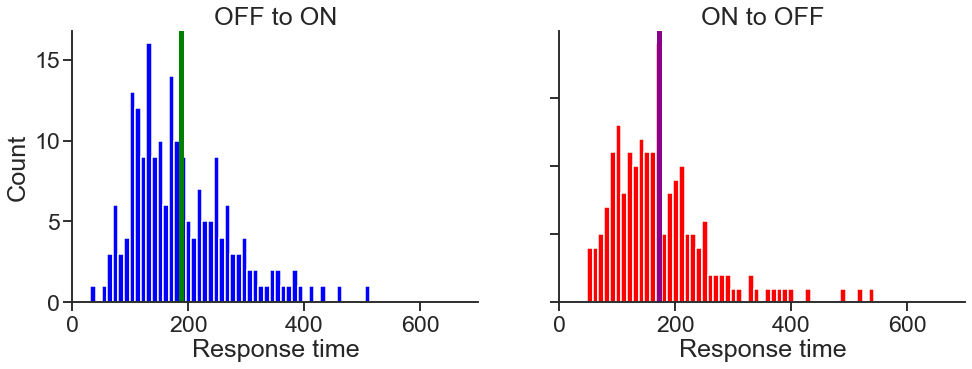

In [248]:
print('Case 2, High k_yz')
# Create figure and plot 
fig, axs = plt.subplots(1, 2, figsize=(16,5))
axs[0].hist(response_time_off_to_on,bins=50,color='blue')
axs[0].set_title('OFF to ON')
axs[0].axvline(x=np.mean(response_time_off_to_on),color='green',
              linewidth=5)

axs[1].hist(response_time_on_to_off,bins=50,color='red')
axs[1].set_title('ON to OFF')
axs[1].axvline(x=np.mean(response_time_on_to_off),color='darkmagenta',
              linewidth=5)

# for ax in axs.flat:
#     ax.set(xlabel='Response time', ylabel='Count',)
for ax in axs.flat:
    ax.set(xlabel='Response time', ylabel='Count',
          xlim=(0,700))
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

sns.despine()
    
plt.show()

In [249]:
# Case 2 - Response time calculation - low k_yz
By = 1; beta_y = 3; alpha_y = 0.01;
Bz = 1; beta_z = 3; alpha_z = 0.01;
k_xy = 1; k_xz = 1; k_yz = 0.01 *10**0;
h = 0.1
y_0 = 10
z_0 = 10
x = np.array([y_0,z_0]).reshape(1,2)
T = 10000
time_on_init = T//3
time_on_end = 2*T//3

Num_realizations = 200
response_time_off_to_on = np.zeros(Num_realizations)
response_time_on_to_off = np.zeros(Num_realizations)
threshold = 5

# @jit()
for i in range(Num_realizations):
    start_time = time.time() # start timing
    np.random.seed(i)
    x = np.array([y_0,z_0]).reshape(1,2)
    x,t_x = sim_case2(x,By,beta_y,alpha_y,Bz,beta_z,alpha_z,
                      k_xy,k_xz,k_yz,T,time_on_init,time_on_end)
    # Compute OFF to ON response time
    indx_start_X_on = np.argmin(np.abs(t_x-T//3))
    indx_end_X_on = np.argmin(np.abs(t_x-2*T//3))
    x_mean_X_on = np.mean(x[indx_start_X_on:indx_end_X_on,1])
    response_time_off_to_on[i] = t_x[(np.abs(x[:,1]-x_mean_X_on)<threshold) 
                                     & (t_x>time_on_init)][0] - time_on_init
    # Compute ON to OFF response time
    x_mean_X_off = np.mean(x[indx_end_X_on:-1,1])
    response_time_on_to_off[i] = t_x[(np.abs(x[:,1]-x_mean_X_off)<threshold) 
                                     & (t_x>time_on_end)][0] - time_on_end
    stop_time = time.time() # stop timing
    print('Simulation time:',stop_time-start_time,'sec')


Simulation time: 9.319304943084717 sec
Simulation time: 9.442982912063599 sec
Simulation time: 9.561686038970947 sec
Simulation time: 9.876665115356445 sec
Simulation time: 9.668237924575806 sec
Simulation time: 9.652443885803223 sec
Simulation time: 9.439781188964844 sec
Simulation time: 9.390629768371582 sec
Simulation time: 9.405712127685547 sec
Simulation time: 9.459458112716675 sec
Simulation time: 9.260493040084839 sec
Simulation time: 9.382446050643921 sec
Simulation time: 9.498575925827026 sec
Simulation time: 9.379287719726562 sec
Simulation time: 9.433971881866455 sec
Simulation time: 9.588871955871582 sec
Simulation time: 9.531176805496216 sec
Simulation time: 9.394921064376831 sec
Simulation time: 9.338744163513184 sec
Simulation time: 9.53283405303955 sec
Simulation time: 9.416888952255249 sec
Simulation time: 9.479783296585083 sec
Simulation time: 9.548973798751831 sec
Simulation time: 9.399590253829956 sec
Simulation time: 9.410275936126709 sec
Simulation time: 9.4832880

Case 2, Low k_yz


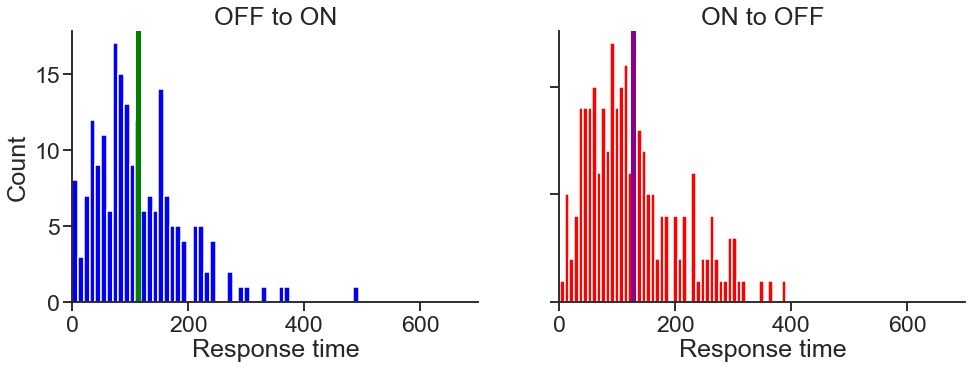

In [250]:
print('Case 2, Low k_yz')
# Create figure and plot 
fig, axs = plt.subplots(1, 2, figsize=(16,5))
axs[0].hist(response_time_off_to_on,bins=50,color='blue')
axs[0].set_title('OFF to ON')
axs[0].axvline(x=np.mean(response_time_off_to_on),color='green',
              linewidth=5)

axs[1].hist(response_time_on_to_off,bins=50,color='red')
axs[1].set_title('ON to OFF')
axs[1].axvline(x=np.mean(response_time_on_to_off),color='darkmagenta',
              linewidth=5)

for ax in axs.flat:
    ax.set(xlabel='Response time', ylabel='Count',
          xlim=(0,700))
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

sns.despine()
    
plt.show()

## What's the distribution of $Z$ when $X_*=1$?

In [260]:
# Case 1 - sample simulation
By = 1; beta_y = 3; alpha_y = 0.01;
Bz = 1; beta_z = 3; alpha_z = 0.01;
k_xy = 1; k_xz = 1; k_yz = 0.01 *10**0; # Strong Y-Z regulation.
h = 0.1
y_0 = 200
z_0 = 200
x = np.array([y_0,z_0]).reshape(1,2)
T = 10000
time_on_init = 0
time_on_end = T+1

np.random.seed(20)

x1,t_x1 = sim_case1(x,By,beta_y,alpha_y,Bz,beta_z,alpha_z,k_xy,k_xz,k_yz,
                  T,time_on_init,time_on_end)

x2,t_x2 = sim_case2(x,By,beta_y,alpha_y,Bz,beta_z,alpha_z,k_xy,k_xz,k_yz,
                  T,time_on_init,time_on_end)


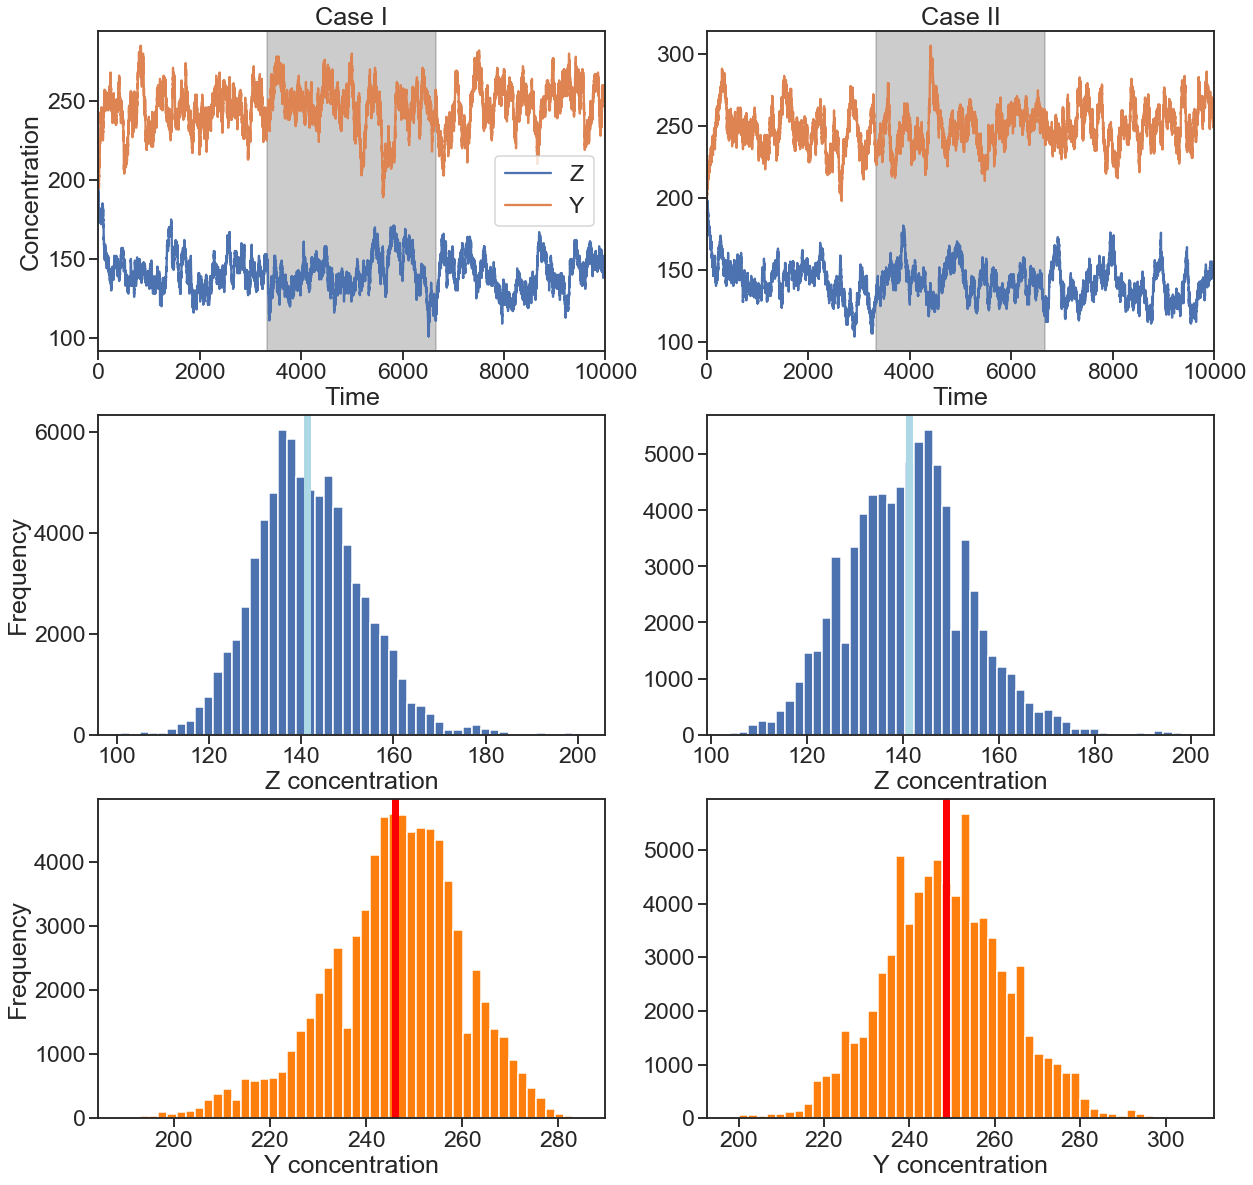

In [292]:
# Plot time series and histogram for case I and II
fig, axs = plt.subplots(3, 2, figsize=(20,20))
axs[0, 0].plot(t_x1, x1[:,1],label='Z')
axs[0, 0].plot(t_x1, x1[:,0],label='Y')
axs[0, 0].set_title('Case I')
axs[0, 0].legend()
axs[0, 0].axvspan(time_on_init, time_on_end, alpha=0.2, color='black')
axs[0, 0].set(xlabel='Time', ylabel='Concentration',xlim=((0,T)))

axs[0, 1].plot(t_x2, x2[:,1])
axs[0, 1].plot(t_x2, x2[:,0])
axs[0, 1].set_title('Case II')
axs[0, 1].axvspan(time_on_init, time_on_end, alpha=0.2, color='black')
axs[0, 1].set(xlabel='Time',xlim=((0,T)))

axs[1, 0].hist(x1[:,1],bins=50)
axs[1, 0].axvline(x=np.mean(x1[:,1]), color='lightblue',linewidth=7)
axs[1, 0].set(xlabel='Z concentration', ylabel='Frequency')

axs[1, 1].hist(x2[:,1],bins=50)
axs[1, 1].axvline(x=np.mean(x2[:,1]), color='lightblue',linewidth=7)
axs[1, 1].set(xlabel='Z concentration')

axs[2, 0].hist(x1[:,0],bins=50,color='tab:orange')
axs[2, 0].axvline(x=np.mean(x1[:,0]), color='red',linewidth=7)
axs[2, 0].set(xlabel='Y concentration', ylabel='Frequency')

axs[2, 1].hist(x2[:,0],bins=50,color='tab:orange')
axs[2, 1].axvline(x=np.mean(x2[:,0]), color='red',linewidth=7)
axs[2, 1].set(xlabel='Y concentration')

# # Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

plt.show()
    

In [290]:
# Kolmogorov - Smirnov Test on Z distribution
from scipy import stats
stats.ks_2samp(x1[:,1],x2[:,1])

Ks_2sampResult(statistic=0.040596293250304644, pvalue=4.679148614346877e-56)

In [291]:
# Kolmogorov - Smirnov Test on Y distribution
stats.ks_2samp(x1[:,0],x2[:,0])

Ks_2sampResult(statistic=0.06574705996682395, pvalue=2.440342644739728e-146)

In [301]:
print('Mean Z case I', round(np.mean(x1[:,1]),3), 'Mean Z in case II', round(np.mean(x2[:,1]),3))
print('Mean Y case I', round(np.mean(x1[:,0]),3), 'Mean Y in case II', round(np.mean(x2[:,0]),3))
print('Std Z case I', round(np.std(x1[:,1]),3), 'Std Z in case II', round(np.std(x2[:,1]),3))
print('Std Y case I', round(np.std(x1[:,0]),3), 'Std Y in case II', round(np.std(x2[:,0]),3))

Mean Z case I 141.259 Mean Z in case II 141.213
Mean Y case I 245.993 Mean Y in case II 248.636
Std Z case I 11.601 Std Z in case II 12.57
Std Y case I 14.172 Std Y in case II 14.521
